## Considerations for PCA Analysis

- leave out target variable for PCA
- do pca only on related / correlated features to get a combined feature


## TODOs
- provide per column explanations and interpretations for the original features
- fix (coords in last scatter plot don't match loadings)
- interpretation of alcohol consumption (correlated with higher std of living!)
- reduce number of features by merging related features using their PCs

In [ ]:
%matplotlib widget

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from typing import Iterable, Optional


In [ ]:
data_dir = Path.cwd().parents[1] / "_data"

assert data_dir.exists(), data_dir
list(data_dir.glob("*.csv"))


[WindowsPath('c:/Users/chris/Documents/GitHub/ama_ws25/_data/life_expectancy_data.csv'),
 WindowsPath('c:/Users/chris/Documents/GitHub/ama_ws25/_data/milk.csv'),
 WindowsPath('c:/Users/chris/Documents/GitHub/ama_ws25/_data/siebenkampf.csv')]

In [ ]:
df = (
    pd.read_csv(data_dir / "life_expectancy_data.csv")
    .pipe(
        lambda d: d.set_axis(
            d.columns.str.strip()
            .str.lower()
            .str.replace(" ", "_")
            .str.replace("__+", "_", regex=True),
            axis=1,
        )
    )
    .assign(
        year=lambda d: pd.to_datetime(d.year.astype(str), format="%Y", errors="coerce"),
    )
    .pipe(
        lambda d: d.assign(
            **{
                col: pd.to_numeric(d[col], errors="coerce")
                for col in d.columns
                if col not in {"country", "status", "year"}
            }
        )
    )
)
df.head()


,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015-01-01,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014-01-01,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013-01-01,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012-01-01,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011-01-01,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## TODO
- filter outliners
- 

In [ ]:
def concatColumns(
    df: pd.DataFrame,
    columns: Optional[Iterable[str]] = None,
    new_column_name: str = "concatenated",
    drop_original: bool = True,
) -> pd.DataFrame:
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    # Choose columns: provided or all numeric
    if columns is None:
        num_df = df.select_dtypes(include=["number"]).copy()
        selected_columns = list(num_df.columns)
    else:
        selected_columns = [c for c in columns if c in df.columns]
        if len(selected_columns) == 0:
            raise ValueError(
                "None of the specified columns are present in the DataFrame"
            )
        num_df = df[selected_columns].copy()

    num_df = num_df.dropna(axis=1, how="all")
    if num_df.shape[1] == 0:
        raise ValueError(
            "No numeric columns available to combine after filtering; nothing to do."
        )

    if num_df.shape[1] == 1:
        print(
            f"Only one column '{num_df.columns[0]}' selected for concatenation. No PCA performed."
        )
        if drop_original:
            result = df.drop(columns=num_df.columns[0])
        else:
            result = df.copy()
        result[new_column_name] = df[
            num_df.columns[0]
        ]  # Take from original df to handle potential NA in num_df
        # For the Quarto section, you'd state: "Only one column was available, so it was directly used as the new feature, explaining 100% of its own variance."
        return result

    # 1. Apply NaN handling (using fillna(0) as per your original logic)
    filled_num_df = num_df.fillna(0)

    # 2. Standardize the data before PCA
    scaler = StandardScaler()
    scaled_num_df = pd.DataFrame(
        scaler.fit_transform(filled_num_df),
        columns=filled_num_df.columns,
        index=filled_num_df.index,
    )

    pca = PCA(n_components=1)
    pc = pca.fit(scaled_num_df)

    explained_variance_ratio_pc1 = (
        pc.explained_variance_ratio_[0] * 100
    )  # Convert to percentage
    print(f"PCA performed on {len(selected_columns)} columns (after NA filtering).")
    print(
        f"The first principal component (PC1) explains {explained_variance_ratio_pc1:.2f}% of the variance within these columns."
    )

    loadings = (
        pd.DataFrame(pc.components_.T, index=num_df.columns, columns=["loading"])
        .reset_index()
        .rename(columns={"index": "feature"})
    )
    loadings["loading"] **= 2
    print("PCA loadings, weighted (squared for component contribution):")
    print(loadings)

    weights = loadings.set_index("feature")["loading"]
    available = [f for f in weights.index if f in num_df.columns]
    if len(available) == 0:
        raise ValueError(
            "None of the PCA features are present in the DataFrame columns"
        )
    selected = num_df[available].fillna(
        0
    )  # Using fillna(0) for selected here too for consistency
    weighted_series = selected.mul(weights.loc[available], axis=1).sum(
        axis=1
    )  # This is your new column

    if drop_original:
        result = df.drop(columns=available)
    else:
        result = df.copy()
    result[new_column_name] = weighted_series
    return result


In [ ]:
print(df.columns)
df = concatColumns(
    df, columns=["diphtheria", "polio", "hepatitis_b"], new_column_name="Immunisation"
)
df = concatColumns(
    df,
    columns=["thinness_5-9_years", "thinness_1-19_years"],
    new_column_name="Child Thinness",
)
df = concatColumns(
    df, columns=["under-five_deaths", "infant_deaths"], new_column_name="Baby Deaths"
)


Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')
PCA performed on 3 columns (after NA filtering).
The first principal component (PC1) explains 69.48% of the variance within these columns.
PCA loadings, weighted (squared for component contribution):
       feature   loading
0   diphtheria  0.381350
1        polio  0.355491
2  hepatitis_b  0.263158
PCA performed on 2 columns (after NA filtering).
The first principal component (PC1) explains 97.00% of the variance within these columns.
PCA loadings, weighted (squared for component contribution):
               feature  loading
0   thinness_5-9_years      0.5
1  thinness_1-19_years      0.5
P

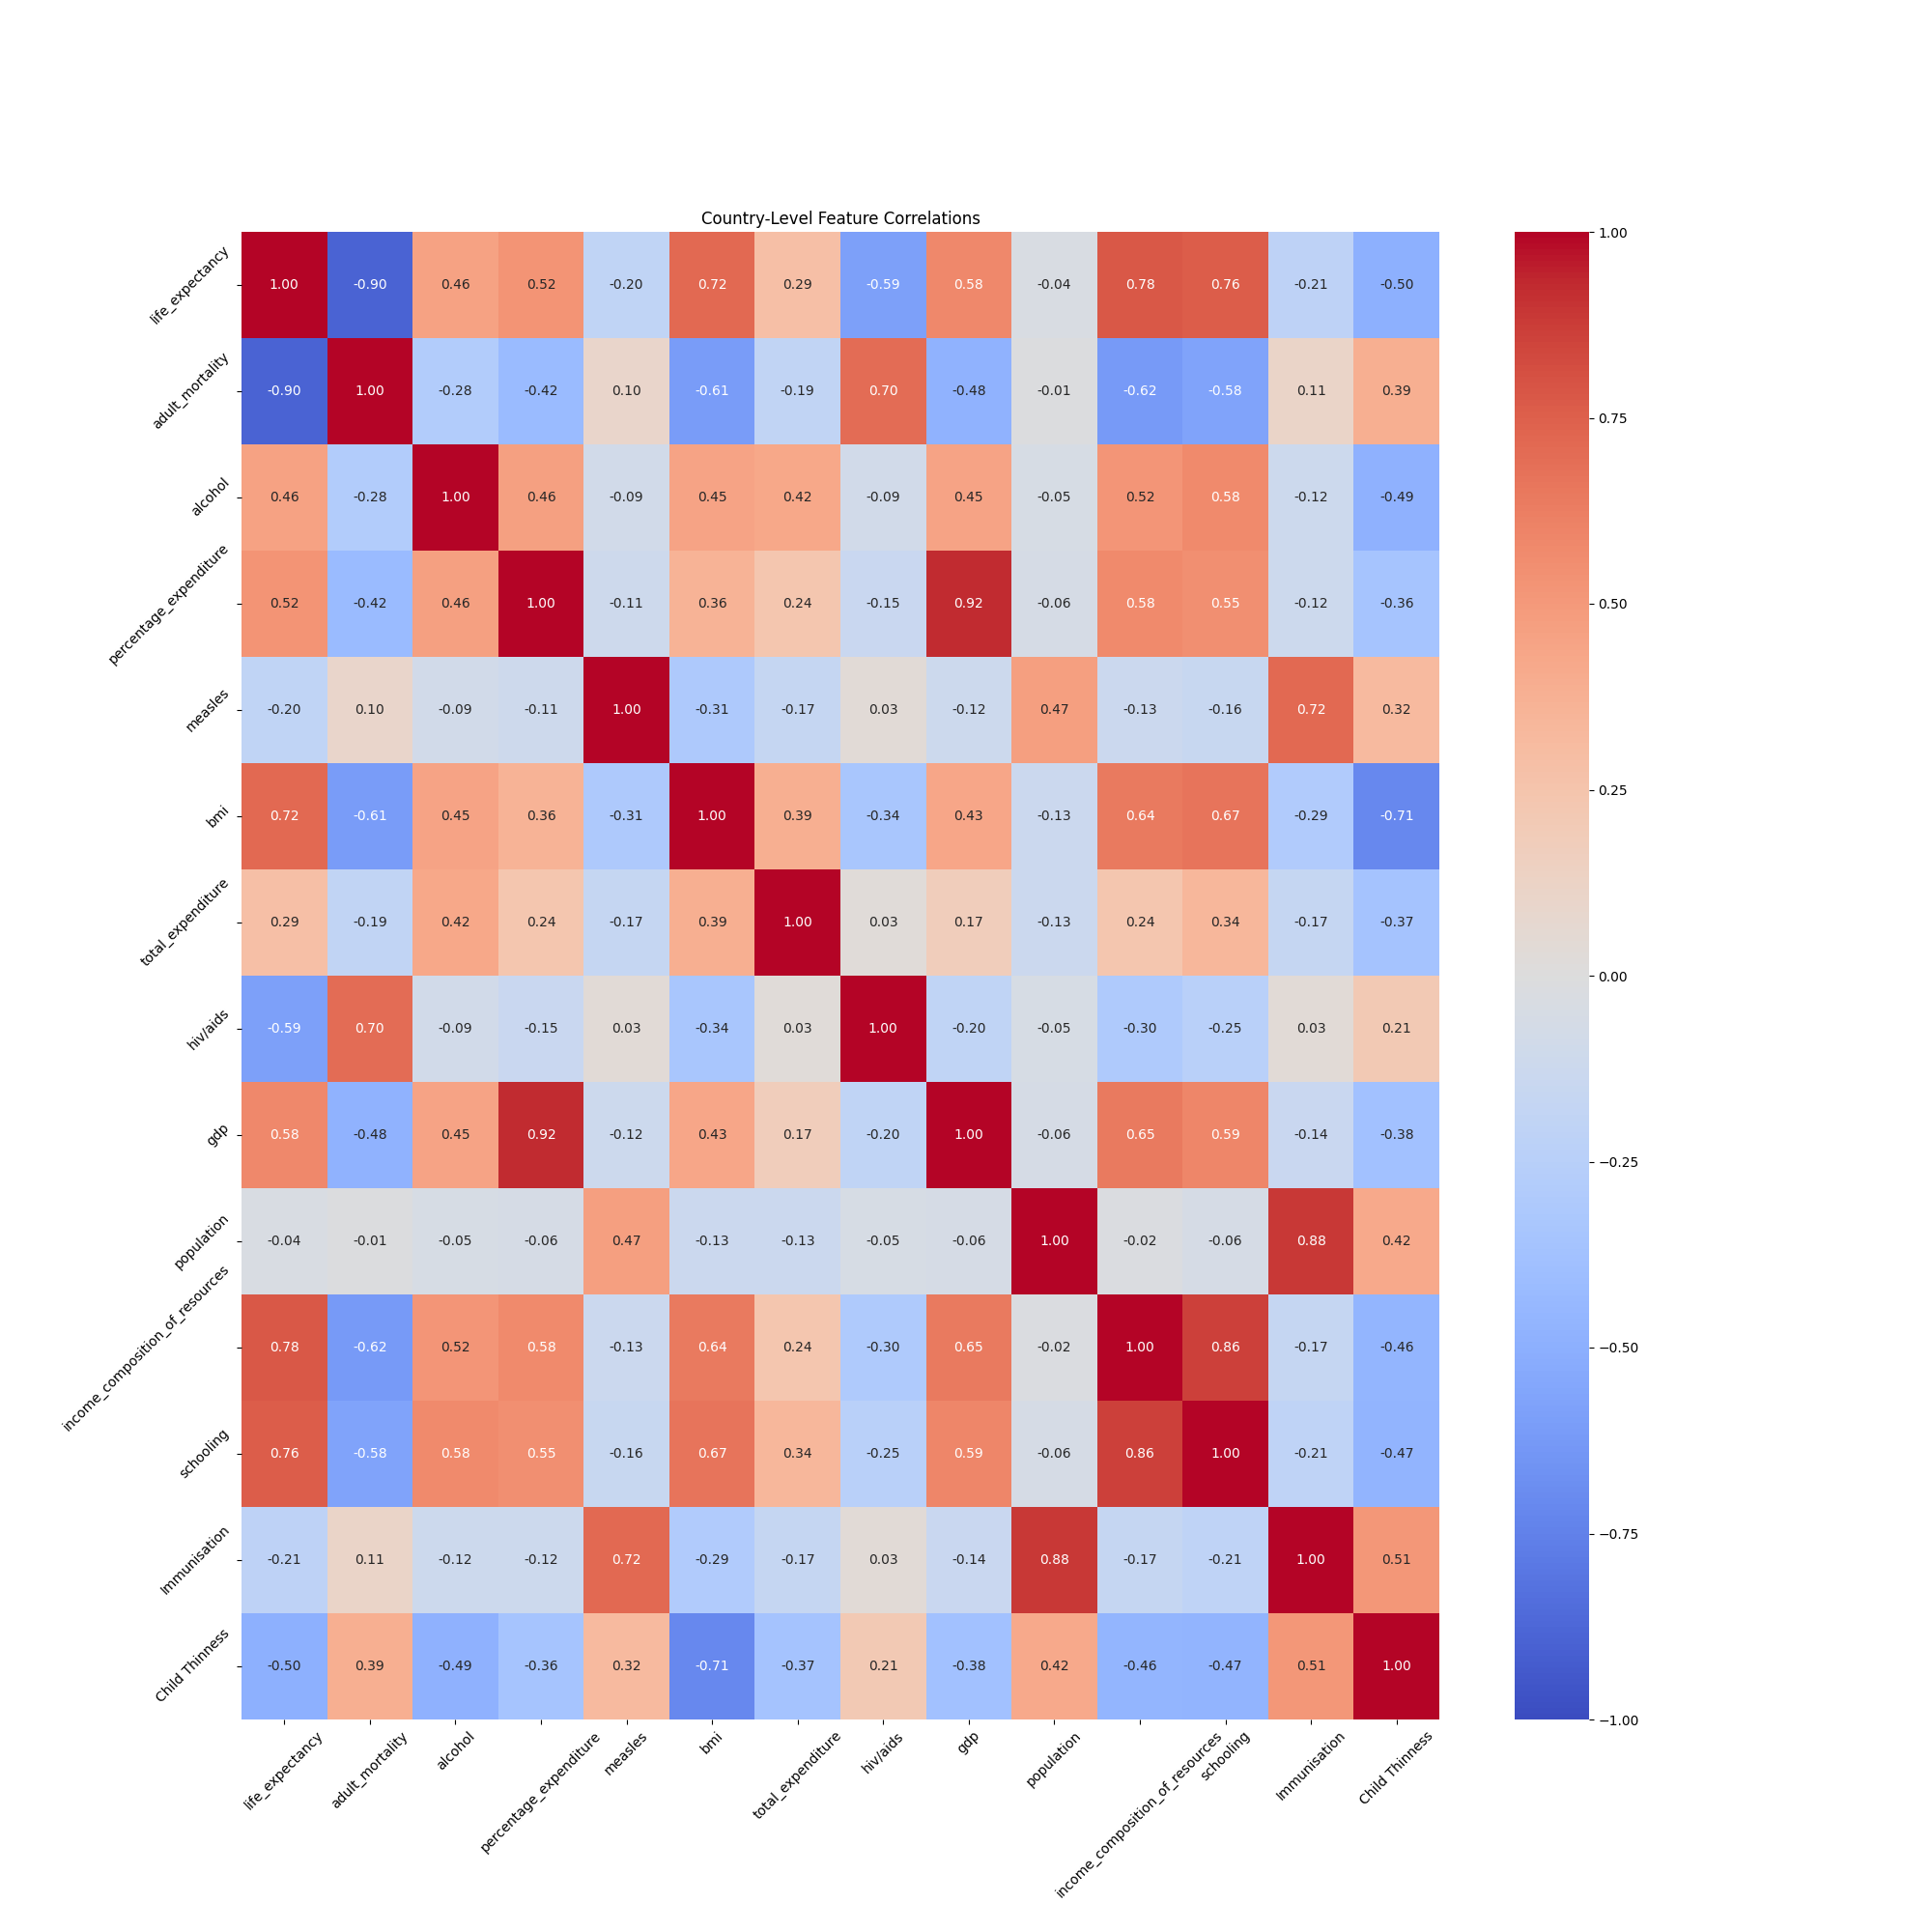

,country,life_expectancy,adult_mortality,alcohol,percentage_expenditure,measles,bmi,total_expenditure,hiv/aids,gdp,population,income_composition_of_resources,schooling,Immunisation,Child Thinness
0,Afghanistan,58.19375,269.0625,0.014375,34.960110,2362.2500,15.51875,8.252500,0.10000,340.015425,9.972260e+06,0.415375,8.21250,92.90625,16.081250
1,Albania,75.15625,45.0625,4.848750,193.259091,53.3750,49.06875,5.945625,0.10000,2119.726679,6.969116e+05,0.709875,12.13750,0.81250,1.659375
2,Algeria,73.61875,108.1875,0.406667,236.185241,1943.8750,48.74375,4.604000,0.10000,2847.853392,2.164983e+07,0.694875,12.71250,21.90625,6.034375
3,Angola,49.01875,328.5625,5.740667,102.100268,3561.3125,18.01875,3.919333,2.36875,1975.143045,1.014710e+07,0.458375,8.04375,108.18750,6.431250
4,Antigua and Barbuda,75.05625,127.5000,7.949333,1001.585226,0.0000,38.42500,4.791333,0.12500,9759.305728,1.274585e+07,0.488625,8.84375,0.00000,3.400000


In [ ]:
df = (
    df.dropna(subset=["life_expectancy"])
    .groupby("country", as_index=False)
    .mean(numeric_only=True)
    .pipe(
        lambda d: d.assign(
            **{
                col: d[col].fillna(d[col].mean())
                for col in d.columns
                if col != "country"
            }
        )
    )
)

plt.figure(figsize=(20, 20))
(
    df.drop(columns=["country"])
    .corr()
    .pipe(
        lambda d: sns.heatmap(
            d,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
        )
    )
)
plt.tick_params(axis="both", rotation=45)
plt.title("Country-Level Feature Correlations")
plt.show()
df.head()


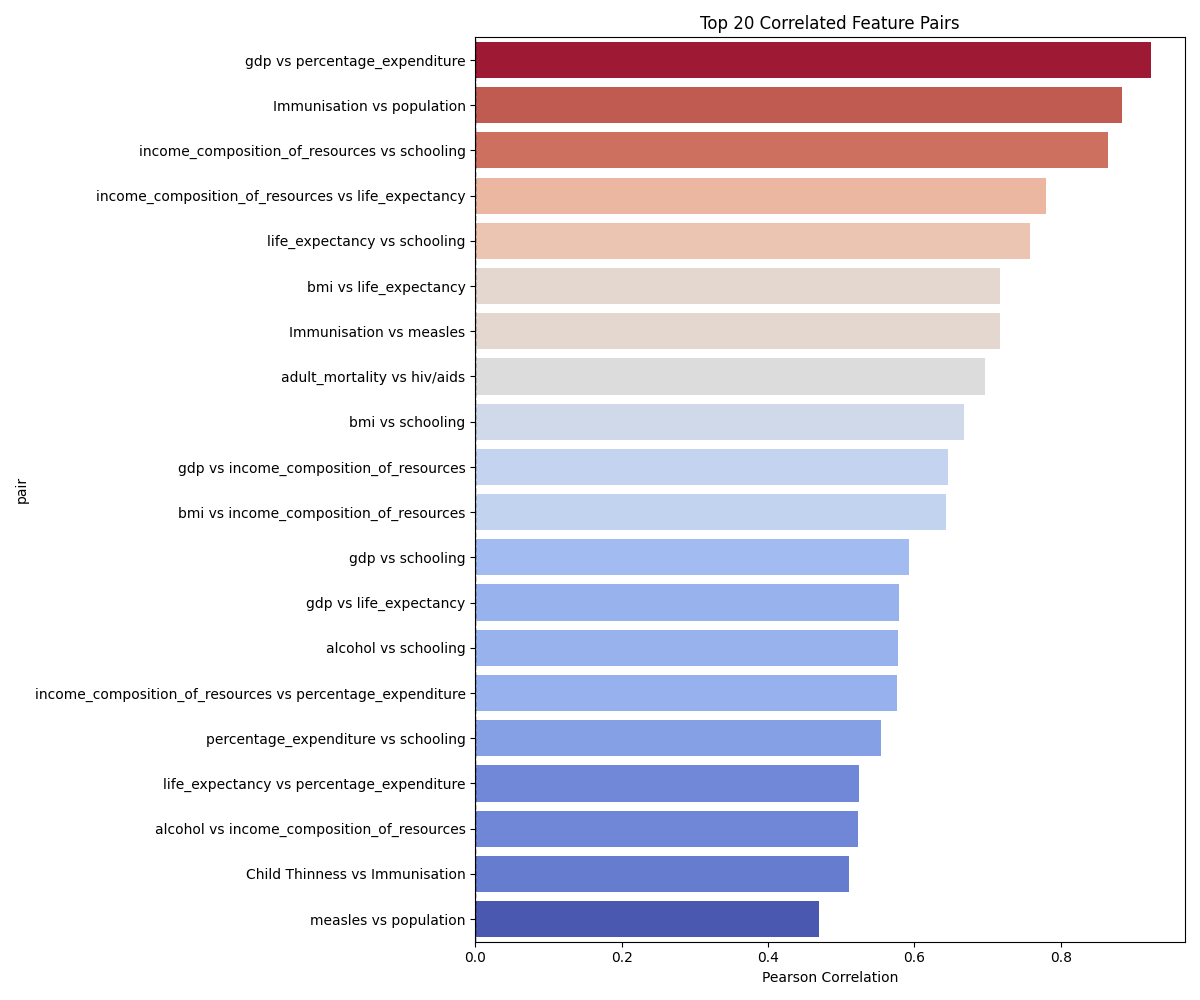

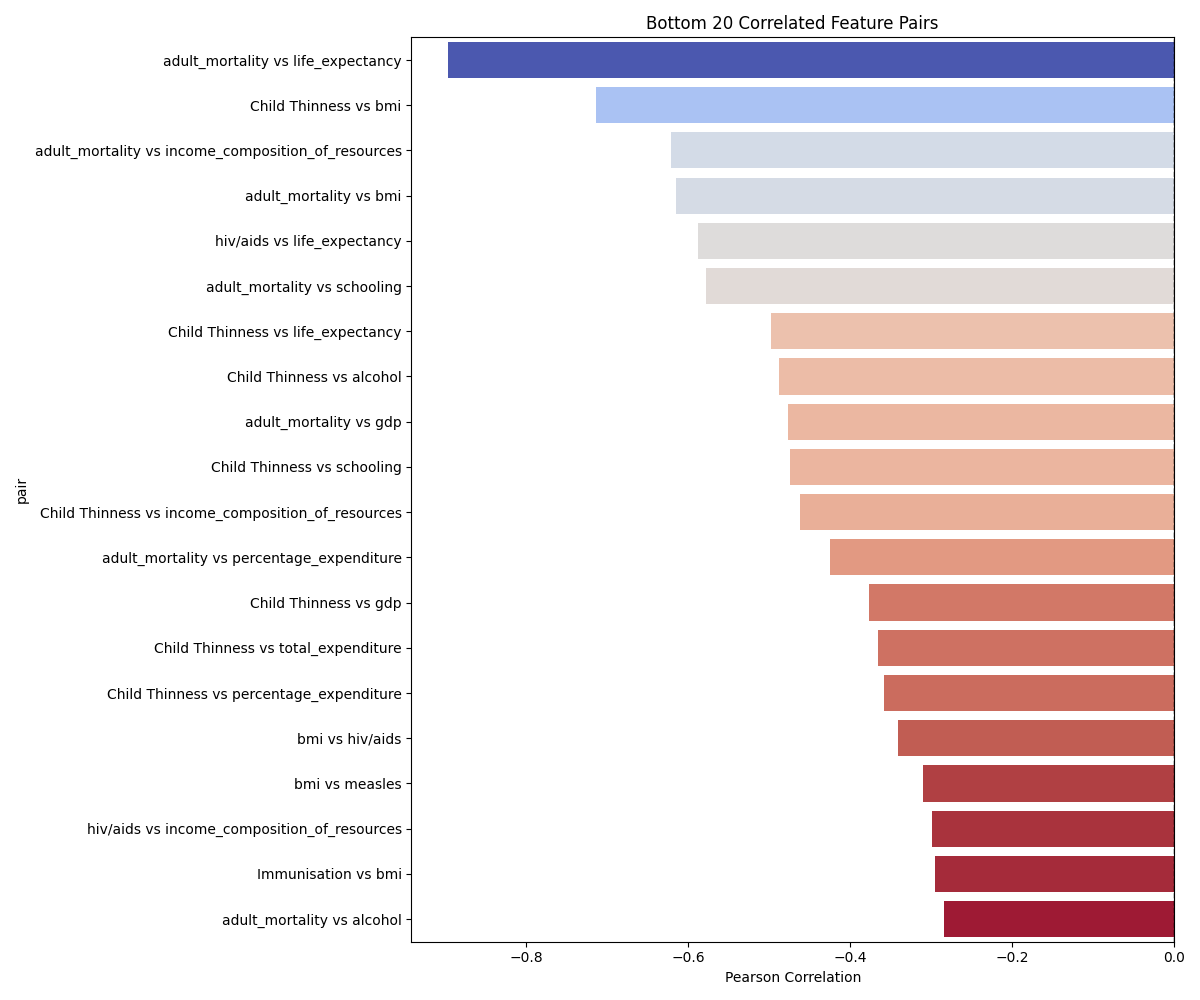

In [ ]:
corr_pairs = (
    df.drop(columns=["country"])
    .corr()
    .stack()
    .reset_index(name="correlation")
    .query("level_0 < level_1")
    .assign(
        pair=lambda d: d.level_0 + " vs " + d.level_1,
        corr=lambda d: d.correlation,
    )
    .sort_values("correlation", ascending=False)
    .assign(rank=lambda d: d.index + 1)
)
corr_pairs.head(10)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.head(20),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
)
plt.title("Top 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.tail(20).sort_values("correlation"),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
)
plt.title("Bottom 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_39116\680551281.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


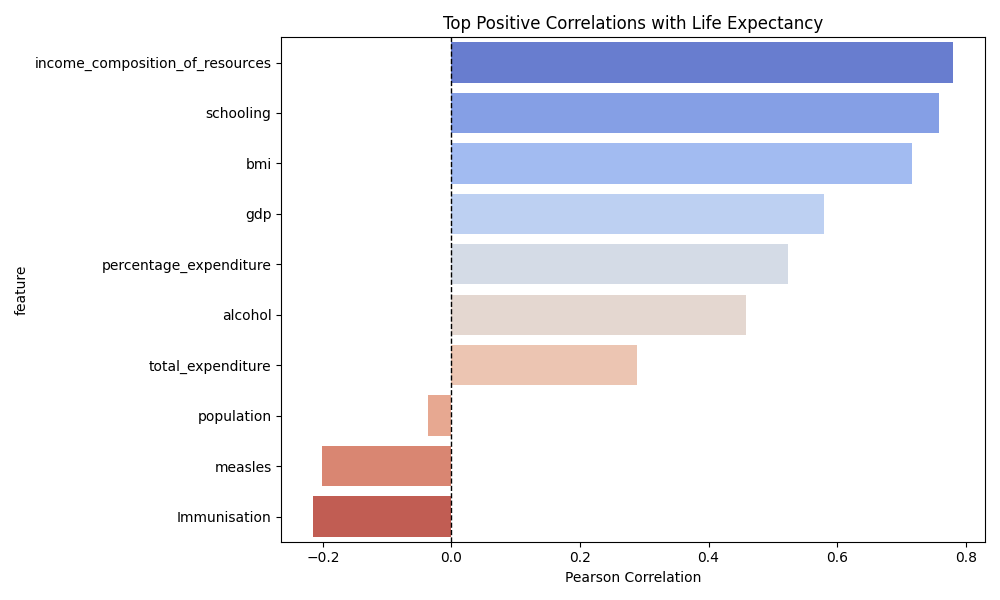

C:\Users\chris\AppData\Local\Temp\ipykernel_39116\680551281.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


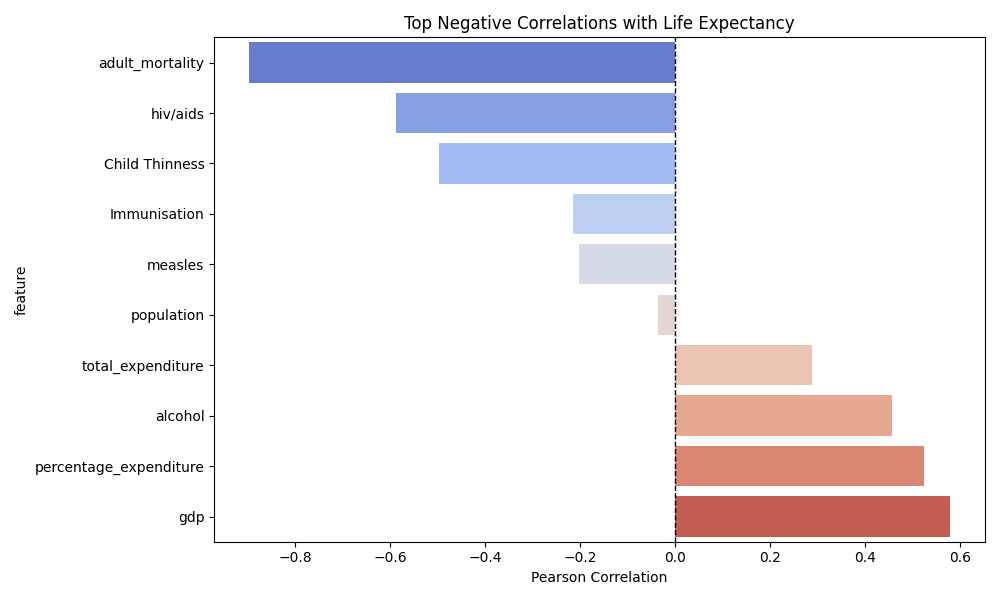

In [ ]:
life_corr = (
    df.drop(columns=["country"])
    .corr()
    .loc["life_expectancy"]
    .drop("life_expectancy")
    .sort_values(ascending=False)
    .to_frame(name="correlation")
    .assign(feature=lambda d: d.index)
    .reset_index(drop=True)
)
life_corr.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.head(10),
    x="correlation",
    y="feature",
    palette="coolwarm",
)
plt.title("Top Positive Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.tail(10).sort_values("correlation"),
    x="correlation",
    y="feature",
    palette="coolwarm",
)
plt.title("Top Negative Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()


In [ ]:
std_cols = df.drop(columns=["country"]).columns

df_std = df.pipe(
    lambda d: pd.concat(
        [
            d[["country"]],
            pd.DataFrame(
                StandardScaler().fit_transform(d[std_cols]),
                columns=std_cols,
                index=d.index,
            ),
        ],
        axis=1,
    )
)
df.head()


,country,life_expectancy,adult_mortality,alcohol,percentage_expenditure,measles,bmi,total_expenditure,hiv/aids,gdp,population,income_composition_of_resources,schooling,Immunisation,Child Thinness
0,Afghanistan,58.19375,269.0625,0.014375,34.960110,2362.2500,15.51875,8.252500,0.10000,340.015425,9.972260e+06,0.415375,8.21250,92.90625,16.081250
1,Albania,75.15625,45.0625,4.848750,193.259091,53.3750,49.06875,5.945625,0.10000,2119.726679,6.969116e+05,0.709875,12.13750,0.81250,1.659375
2,Algeria,73.61875,108.1875,0.406667,236.185241,1943.8750,48.74375,4.604000,0.10000,2847.853392,2.164983e+07,0.694875,12.71250,21.90625,6.034375
3,Angola,49.01875,328.5625,5.740667,102.100268,3561.3125,18.01875,3.919333,2.36875,1975.143045,1.014710e+07,0.458375,8.04375,108.18750,6.431250
4,Antigua and Barbuda,75.05625,127.5000,7.949333,1001.585226,0.0000,38.42500,4.791333,0.12500,9759.305728,1.274585e+07,0.488625,8.84375,0.00000,3.400000


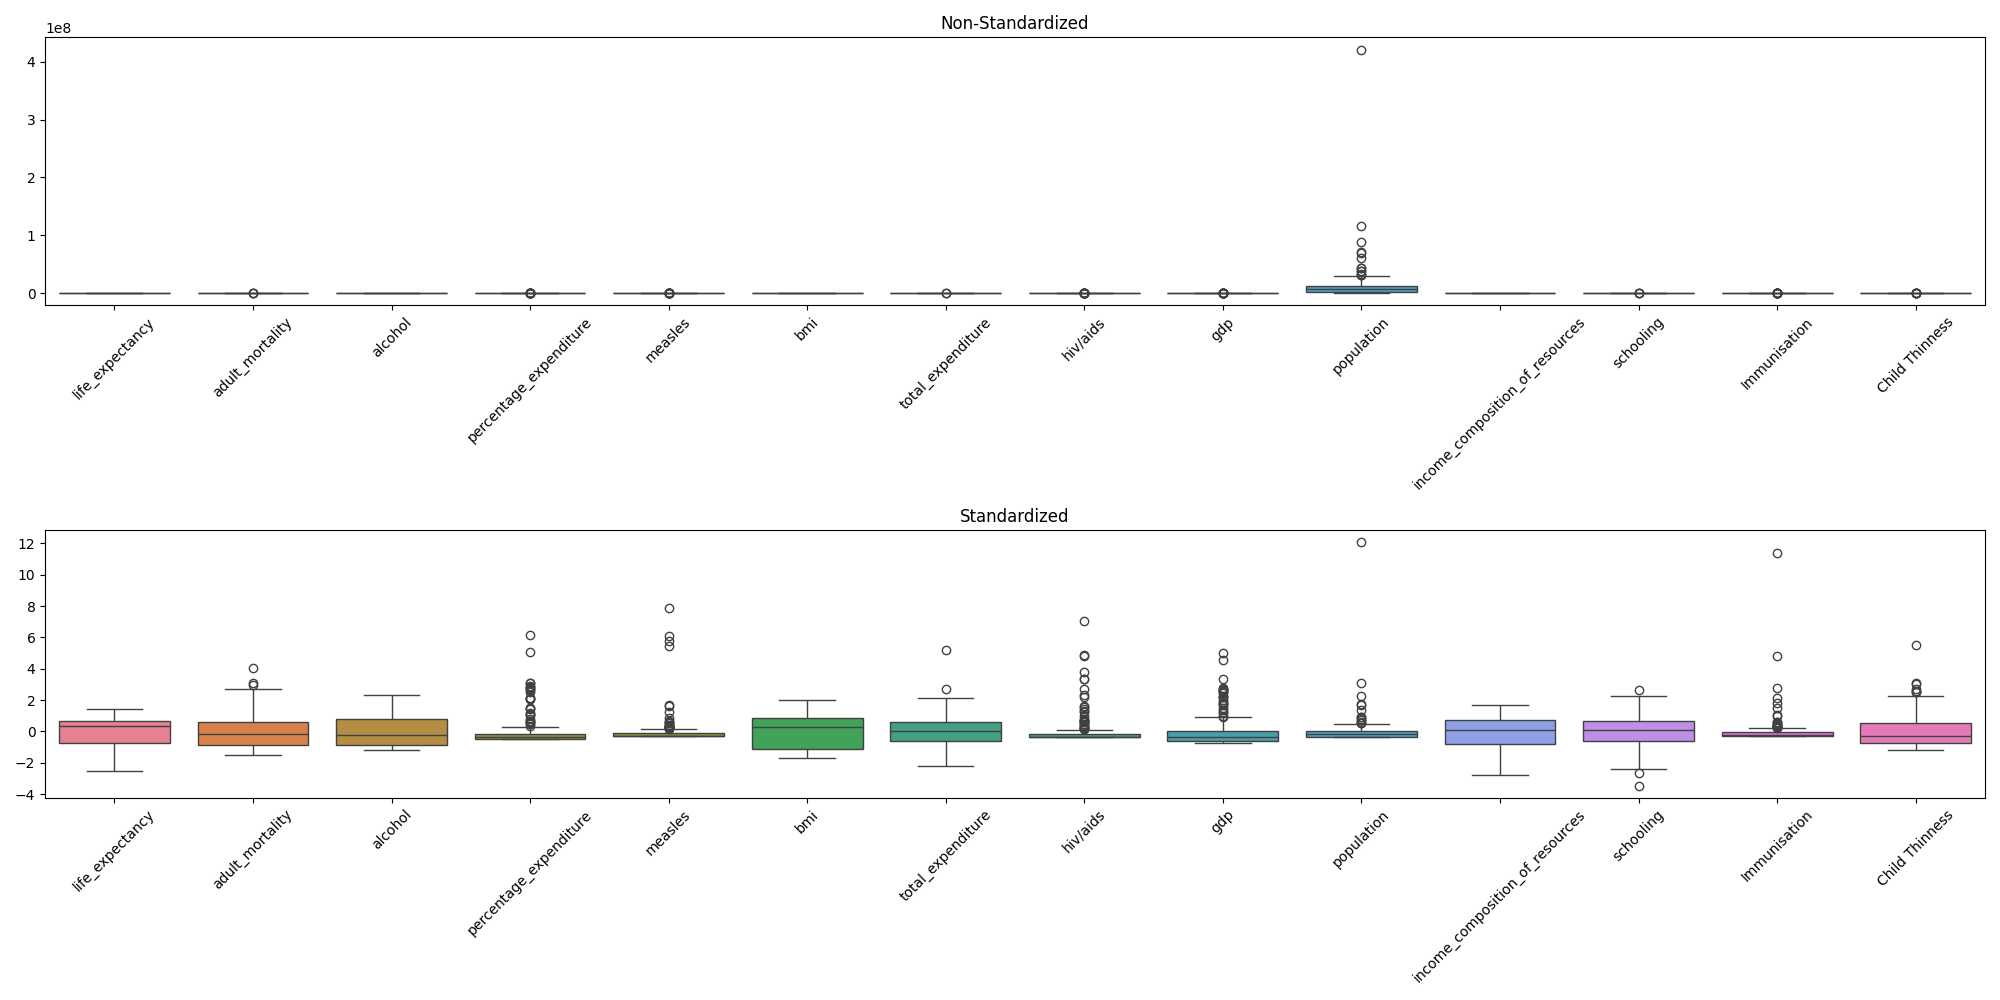

In [ ]:
_, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.boxplot(data=df[std_cols], ax=axs[0])
axs[0].tick_params(axis="x", rotation=45)
axs[0].set_title("Non-Standardized")

sns.boxplot(data=df_std[std_cols], ax=axs[1])
axs[1].tick_params(axis="x", rotation=45)
axs[1].set_title("Standardized")

plt.tight_layout()
plt.show()


In [ ]:
df_std.describe()


,life_expectancy,adult_mortality,alcohol,percentage_expenditure,measles,bmi,total_expenditure,hiv/aids,gdp,population,income_composition_of_resources,schooling,Immunisation,Child Thinness
count,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02
mean,-7.231617e-16,8.736181e-17,-1.650168e-16,1.456030e-17,-3.397404e-17,1.310427e-16,1.504565e-16,-1.067755e-16,5.824121e-17,-5.824121e-17,2.523786e-16,9.221525e-17,-9.706868e-18,2.184045e-17
std,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00
min,-2.522834e+00,-1.522554e+00,-1.202433e+00,-5.012744e-01,-3.012648e-01,-1.714090e+00,-2.237298e+00,-3.714860e-01,-7.242946e-01,-3.767145e-01,-2.783491e+00,-3.451146e+00,-2.663999e-01,-1.167891e+00
25%,-7.367877e-01,-8.797794e-01,-8.787960e-01,-4.793351e-01,-3.002488e-01,-1.099378e+00,-6.408078e-01,-3.714860e-01,-6.318048e-01,-3.317210e-01,-7.803685e-01,-6.077156e-01,-2.657118e-01,-7.515749e-01
50%,3.561251e-01,-1.900914e-01,-2.376179e-01,-3.769155e-01,-2.795496e-01,2.817446e-01,4.657220e-16,-3.714860e-01,-3.452094e-01,-1.951834e-01,1.134567e-01,7.429555e-02,-2.416268e-01,-2.852100e-01
75%,6.419744e-01,5.712694e-01,7.616863e-01,-1.467274e-01,-1.118890e-01,8.715042e-01,5.964985e-01,-1.692804e-01,1.816907e-16,-1.101330e-16,7.107439e-01,6.501932e-01,-6.878849e-02,5.538676e-01
max,1.453131e+00,4.016451e+00,2.321520e+00,6.135570e+00,7.870833e+00,1.976957e+00,5.217302e+00,7.033325e+00,4.991661e+00,1.208329e+01,1.707041e+00,2.649867e+00,1.140150e+01,5.510606e+00


In [ ]:
df_std = df_std.set_index("country")


In [ ]:
df_std.columns


Index(['life_expectancy', 'adult_mortality', 'alcohol',
       'percentage_expenditure', 'measles', 'bmi', 'total_expenditure',
       'hiv/aids', 'gdp', 'population', 'income_composition_of_resources',
       'schooling', 'Immunisation', 'Child Thinness'],
      dtype='object')

In [ ]:
pred_cols = df_std.columns

pca = PCA()
pca_model = pca.fit(df_std[pred_cols])
pca_model


,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [ ]:
df_std[pred_cols].shape


(183, 14)

In [ ]:
pca_model.components_.shape


(14, 14)

In [ ]:
pca_model.components_[0]


array([ 0.361855  , -0.30902082,  0.25720149,  0.28161231, -0.1329575 ,
        0.32964141,  0.17250743, -0.17904771,  0.2983753 , -0.09088224,
        0.3430113 ,  0.34362789, -0.15795619, -0.28631537])

In [ ]:
loadings = (
    pd.DataFrame(
        pca_model.components_,
        columns=pred_cols,
        index=[f"PC{i + 1}" for i in range(len(pred_cols))],
    )
    .T.reset_index()
    .rename(columns={"index": "feature"})
)
loadings


,feature,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,life_expectancy,0.361855,0.130614,-0.228990,0.023706,-0.007008,-0.112915,0.134782,-0.005538,0.344862,-0.162437,0.058722,0.397772,0.548353,0.400412
1,adult_mortality,-0.309021,-0.179180,0.388777,0.001862,-0.167414,0.035925,-0.115632,0.080341,-0.550508,0.150541,-0.045397,0.297663,0.435777,0.256552
2,alcohol,0.257201,0.039492,0.360851,0.243854,-0.042597,0.247928,0.014629,0.777791,0.221458,0.121208,-0.083644,-0.018016,-0.032638,-0.045089
3,percentage_expenditure,0.281612,0.112948,0.322523,-0.452369,0.325435,0.014966,-0.132958,-0.067802,-0.033342,0.012825,0.165309,-0.458696,0.448503,-0.175242
4,measles,-0.132957,0.442035,0.106486,0.104698,0.023987,0.656015,0.360484,-0.310780,0.037544,0.119537,-0.021337,0.170182,0.117178,-0.219810
5,bmi,0.329641,-0.034862,-0.096278,0.285799,-0.211092,-0.013664,-0.410533,-0.296058,0.073062,0.666422,-0.163545,-0.051638,0.104316,-0.092111
6,total_expenditure,0.172507,-0.096567,0.291616,0.562497,0.591793,-0.277348,0.228924,-0.205992,-0.151803,-0.053598,-0.083647,0.052361,-0.040574,-0.013870
7,hiv/aids,-0.179048,-0.167945,0.599997,0.013996,-0.341367,-0.163278,0.005086,-0.318263,0.559961,-0.143196,0.017574,-0.007287,-0.024723,-0.001089
8,gdp,0.298375,0.120481,0.259397,-0.474694,0.198554,0.015851,-0.151197,-0.092038,-0.035575,0.128654,-0.144942,0.513914,-0.457131,0.144661
9,population,-0.090882,0.546238,0.048160,0.160008,-0.085112,-0.334977,-0.405599,0.093714,-0.075007,-0.251614,0.101516,0.272370,0.075303,-0.462168


In [ ]:
explained_variance = pca_model.explained_variance_ratio_
for i in range(len(explained_variance)):
    print(f"PC{i + 1} explains {explained_variance[i] * 100:.2f}% of the variance.")

explained_variance


PC1 explains 43.49% of the variance.
PC2 explains 17.51% of the variance.
PC3 explains 10.37% of the variance.
PC4 explains 7.81% of the variance.
PC5 explains 4.62% of the variance.
PC6 explains 4.44% of the variance.
PC7 explains 3.51% of the variance.
PC8 explains 3.37% of the variance.
PC9 explains 1.59% of the variance.
PC10 explains 1.19% of the variance.
PC11 explains 0.88% of the variance.
PC12 explains 0.49% of the variance.
PC13 explains 0.44% of the variance.
PC14 explains 0.30% of the variance.


In [ ]:
aggregated_loadings = (
    loadings.set_index("feature")
    .loc[:, ["PC1", "PC2", "PC3", "PC4", "PC5"]]
    .abs()
    .sum(axis=1)
    .sort_values(ascending=False)
)
aggregated_loadings


feature
total_expenditure                  1.714980
percentage_expenditure             1.494888
gdp                                1.351502
hiv/aids                           1.302354
adult_mortality                    1.046255
income_composition_of_resources    0.993218
Immunisation                       0.992966
schooling                          0.979917
bmi                                0.957673
alcohol                            0.943996
population                         0.930401
measles                            0.810165
Child Thinness                     0.808805
life_expectancy                    0.752172
dtype: float64

In [ ]:
top_loading_features = aggregated_loadings.index

top_loading_features


Index(['total_expenditure', 'percentage_expenditure', 'gdp', 'hiv/aids',
       'adult_mortality', 'income_composition_of_resources', 'Immunisation',
       'schooling', 'bmi', 'alcohol', 'population', 'measles',
       'Child Thinness', 'life_expectancy'],
      dtype='object', name='feature')

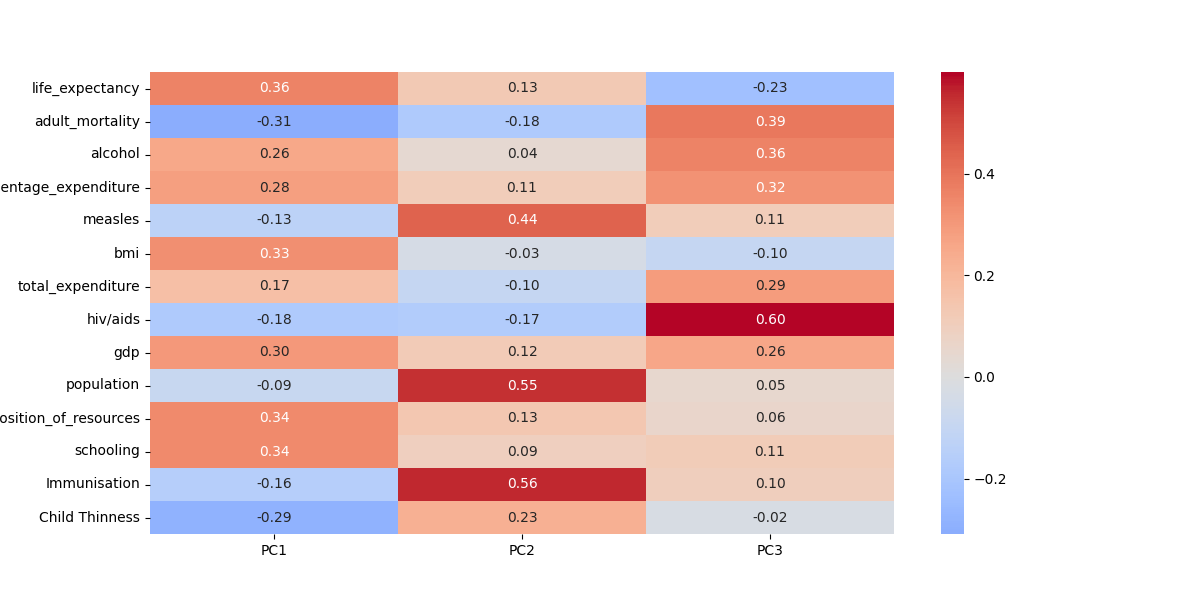

In [ ]:
plt.figure(figsize=(12, 6))

sns.heatmap(
    loadings.query("feature in @top_loading_features")
    .set_index("feature")
    .loc[:, ["PC1", "PC2", "PC3"]],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
)

plt.show()


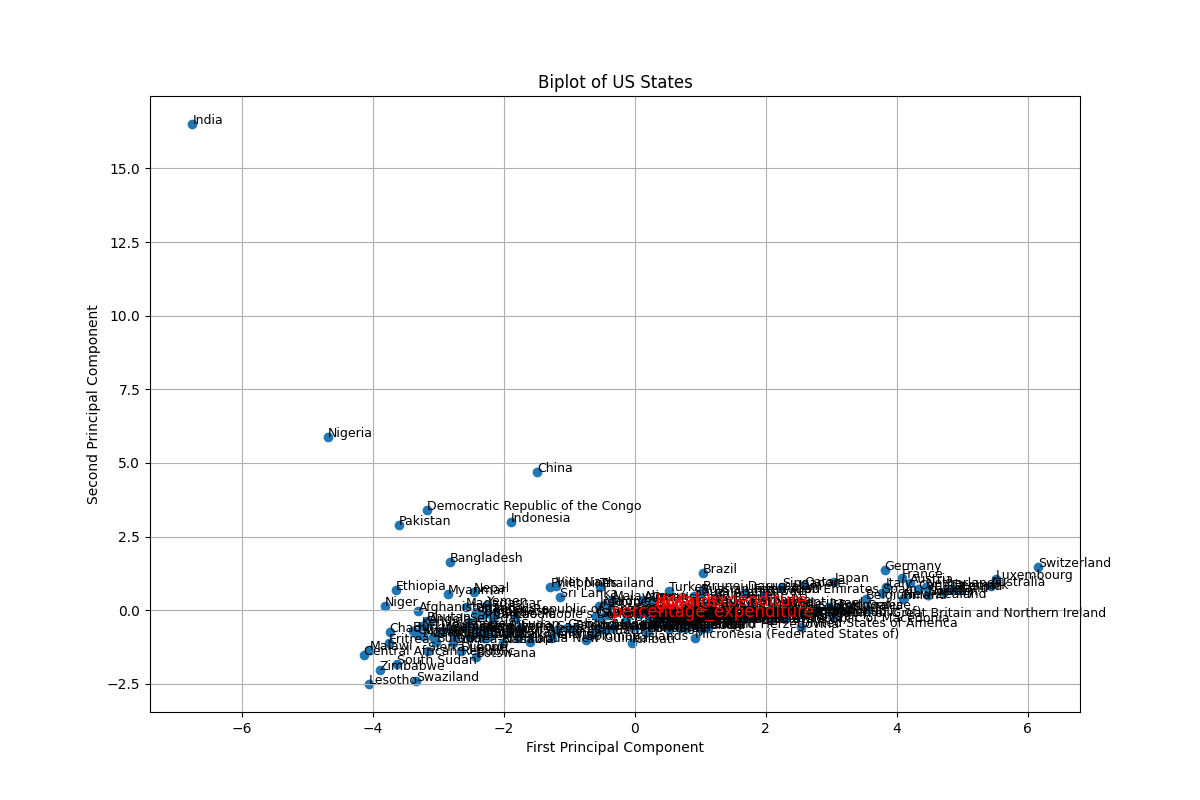

In [ ]:
# Visualize states based on PC1 and PC2
plt.figure(figsize=(12, 8))
pc1 = pca_model.transform(df_std)[:, 0]
pc2 = pca_model.transform(df_std)[:, 1]
plt.scatter(pc1, pc2)

# add labels for each state
for i, state in enumerate(df_std.index):
    plt.text(pc1[i], pc2[i], state, fontsize=9)

# add arrows to illustrate contributions of original variables to the principal components
for i, var in enumerate(top_loading_features[:4]):
    plt.arrow(
        0,
        0,
        pca.components_[0, i],
        pca.components_[1, i],
        color="r",
        alpha=0.5,
        head_width=0.05,
        head_length=0.1,
    )
    plt.text(
        pca.components_[0, i] * 1.15,
        pca.components_[1, i] * 1.15,
        var,
        color="r",
        fontsize=12,
    )

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Biplot of US States")
plt.grid(True)
plt.show()


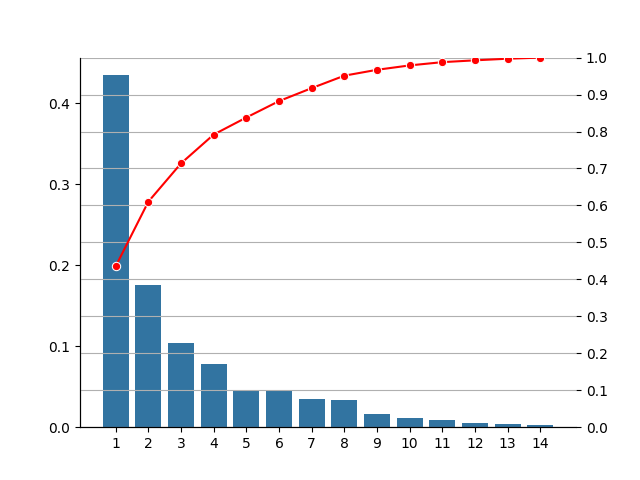

In [ ]:
plt.figure()
ax = sns.barplot(
    x=np.arange(1, len(pred_cols) + 1),
    y=pca_model.explained_variance_ratio_,
)
ax = sns.lineplot(
    x=np.arange(0, len(pred_cols)),
    y=pca_model.explained_variance_ratio_.cumsum(),
    marker="o",
    color="red",
    ax=ax.twinx(),
)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
sns.despine(fig=plt.gcf(), top=True)
plt.show()
